While learning and practising PySpark I came across an interesting, for learning purposes, Medium article analysing Uber Data but soon realised it needed much refinement and started analysing it myself.  
[This is the dataset](https://github.com/ayushdixit487/Uber-Data-Analysis-Project-in-Pyspark/blob/main/dataset.csv) from this [Medium article](https://medium.com/towards-data-engineering/uber-data-analysis-project-in-pyspark-e105a445fc3e).  
  

# Data Description
The dataset used in this project is supposed to be a real-world dataset from Uber, stored in a CSV file. Its columns are:  
* **Date**: date of record  
* **Time (Local)**: time of record (in hours)  
* **Eyeballs**: number of people who opened the App  
* **Zeroes**: number of people who saw no cars  
* **Completed Trips**: number of succesful completed trips  
* **Requests**: number of people who made a request  
* **Unique Drivers**: number of different drivers who had logged in during that hour

Along with the dataset came the assigment, too. "Provide answers to the following questions..."  

# Questions to be answered:
1. Which date had the most completed trips during the two-week period?
2. What was the highest number of completed trips within a 24-hour period?
3. Which hour of the day had the most requests during the two-week period?
4. What percentages of all zeroes during the two-week period occurred on weekend (Friday at 5 pm to Sunday at 3 am)? Tip: The local time value is the start of the hour (e.g. 15 is the hour from 3:00 pm - 4:00 pm)
5. What is the weighted average ratio of completed trips per driver during the two-week period? Tip: “Weighted average” means your answer should account for the total trip volume in each hour to determine the most accurate number in the whole period.
6. In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two-week period in terms of unique requests? A new shift starts every 8 hours. Assume that a driver will work the same shift each day.
7. True or False: Driver supply always increases when demand increases during the two-week period. Tip: Visualize the data to confirm your answer if needed.
8. In which 72-hour period is the ratio of Zeroes to Eyeballs the highest?
9. If you could add 5 drivers to any single hour of every day during the two-week period, which hour should you add them to? Hint: Consider both rider eyeballs and driver supply when choosing
10. Looking at the data from all two weeks, which time might make the most sense to consider a true “end day” instead of midnight? (i.e when are supply and demand at both their natural minimums)

# Create SparkSession and load the dataset
First we'll create a SparkSession and load the dataset into a DataFrame in order to perform any cleaning tasks needed.

In [1]:
import pandas as pd

# Load the dataset using pandas
path = r'C:\Users\nikos\Datasets\UberDataAnalysis\dataset.csv'
pdf = pd.read_csv(path)

# Take a look at the column names, info and first 20 rows of the dataset
print(pdf.columns)
print(pdf.info())
pdf.head(20)

Index(['Date', 'Time (Local)', 'Eyeballs ', 'Zeroes ', 'Completed Trips ',
       'Requests ', 'Unique Drivers'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              15 non-null     object
 1   Time (Local)      336 non-null    int64 
 2   Eyeballs          336 non-null    int64 
 3   Zeroes            336 non-null    int64 
 4   Completed Trips   336 non-null    int64 
 5   Requests          336 non-null    int64 
 6   Unique Drivers    336 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 18.5+ KB
None


,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,10-Sep-12,7,5,0,2,2,9
1,NaN,8,6,0,2,2,14
2,NaN,9,8,3,0,0,14
3,NaN,10,9,2,0,1,14
4,NaN,11,11,1,4,4,11
5,NaN,12,12,0,2,2,11
6,NaN,13,9,1,0,0,9
7,NaN,14,12,1,0,0,9
8,NaN,15,11,2,1,2,7
9,NaN,16,11,2,3,4,6


# Data Cleaning
As we can see there are uneeded spaces at the end of some columns, "Date" column has missing values between each change of date and "Date" and "Time (local)" columns are not of proper type. We will strip trailing whitespaces and combine "Date" and "Time (local)" columns into a "DateTime" column.

In [2]:
# Remove spaces at the end of column names
pdf.columns = pdf.columns.str.strip()

# Forward fill missing 'Date' values
pdf['Date'] = pdf['Date'].ffill()

# Ensure the 'Time (Local)' values are two digits
pdf['Time (Local)'] = pdf['Time (Local)'].apply(lambda x: f'{x:02}')

# Combine 'Date' and 'Time (Local)' to create a datetime column
pdf['DateTime'] = pd.to_datetime(pdf['Date'] + ' ' + pdf['Time (Local)'], format='%d-%b-%y %H')

# Drop 'Date' and 'Time (Local)' columns
pdf = pdf.drop(columns=['Date', 'Time (Local)'])

# Save the cleaned DataFrame back to a CSV file
cleaned_path = r'C:\Users\nikos\Datasets\UberDataAnalysis\cleaned_dataset.csv'
pdf.to_csv(cleaned_path, index=False)
pdf.head()

,Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers,DateTime
0,5,0,2,2,9,2012-09-10 07:00:00
1,6,0,2,2,14,2012-09-10 08:00:00
2,8,3,0,0,14,2012-09-10 09:00:00
3,9,2,0,1,14,2012-09-10 10:00:00
4,11,1,4,4,11,2012-09-10 11:00:00


# Answering The Questions
Now that we have the cleaned dataset it's time to start answering those questions.  

## Which date had the most completed trips during the two-week period?  
Bonus question answered: **How many were they?**

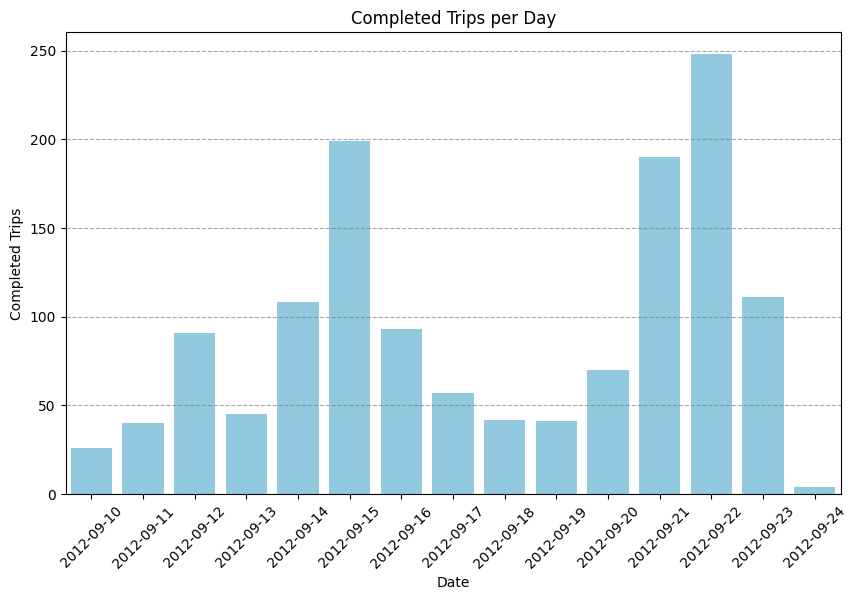

Date with most completed trips: 2012-09-22
Completed trips that day: 248


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns

# Create a SparkSession
spark = SparkSession.builder.appName("UberDataAnalysis").getOrCreate()

# Load the dataset into a  Spark DataFrame
df = spark.read.csv(cleaned_path, header=True, inferSchema=True)

# Group the data by date and sum the completed trips
completed_trips_by_date = df.withColumn("DateTime", date_format(col("DateTime"), "yyyy-MM-dd")).groupBy("DateTime").sum("Completed Trips")

# Find the date with the most completed trips
date_with_most_completed_trips = completed_trips_by_date \
    .orderBy("sum(Completed Trips)", ascending=False) \
    .select("DateTime") \
    .first()["DateTime"]
most_completed_trips_in_a_day = completed_trips_by_date \
    .orderBy("sum(Completed Trips)", ascending=False) \
    .select("sum(Completed Trips)") \
    .first()["sum(Completed Trips)"]

# Convert to Pandas for plotting and sort by DateTime to ensure chronological order
completed_trips_by_date = completed_trips_by_date.toPandas().sort_values(by='DateTime')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=completed_trips_by_date, x="DateTime", y="sum(Completed Trips)", color="skyblue")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Completed Trips")
plt.title("Completed Trips per Day")

# Add grid
plt.grid(visible=True, which='major', axis='y', linestyle='--', color='grey', alpha=0.7)

# Display the plot
plt.show()

print(f"Date with most completed trips: {date_with_most_completed_trips}\nCompleted trips that day: {most_completed_trips_in_a_day}")

## What was the highest number of completed trips within a 24-hour period? 
 Bonus question answered: **Which period was that?**

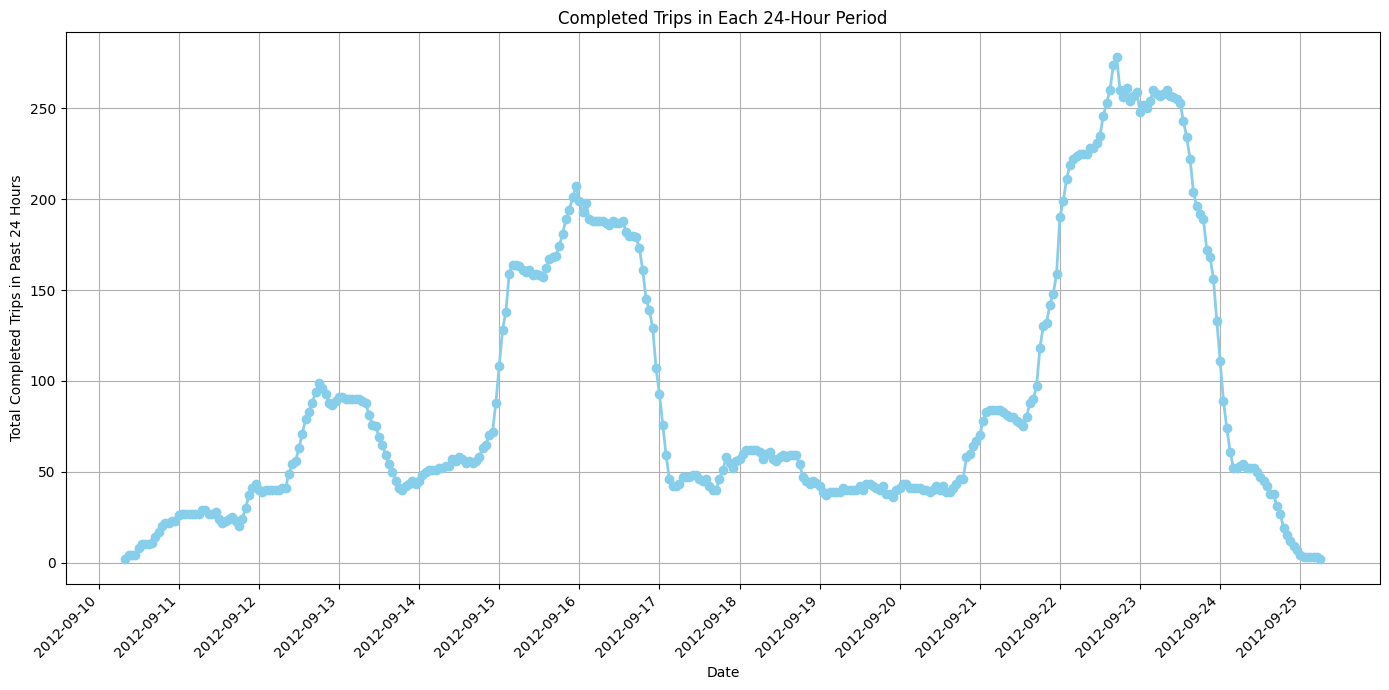

The highest number of completed trips within a 24-hour period was: 278
The specific 24-hour window with the highest number of completed trips was
from 21-09-12 17:00 to 22-09-12 17:00


In [4]:
from pyspark.sql.window import Window
import matplotlib.dates as mdates

# Define the window spec for a rolling 24-hour period
window_spec = window(col('DateTime'), '24 hours', slideDuration='1 hour').alias('window')

# Calculate the sum of 'Completed Trips' over each window
df_with_window = df.groupBy(window_spec).agg(sum('Completed Trips').alias('TotalCompletedTrips'))

# Use a window function to rank the windows by 'TotalCompletedTrips'
window_rank_spec = Window.orderBy(col('TotalCompletedTrips').desc())
df_with_rank = df_with_window.withColumn('rank', row_number().over(window_rank_spec))

# Filter to get the window with the maximum 'TotalCompletedTrips'
max_window_df = df_with_rank.filter(col('rank') == 1).select('window', 'TotalCompletedTrips')

# Collect the result
max_window_result = max_window_df.collect()[0]

# Extract and format the start and end times
start_time = max_window_result['window']['start']
end_time = max_window_result['window']['end']

formatted_start_time = start_time.strftime("%d-%m-%y %H:00")
formatted_end_time = end_time.strftime("%d-%m-%y %H:00")

# Convert to Pandas for plotting
df_with_window_pd = df_with_window.toPandas()

# Split 'window' into separate 'window_start' and 'window_end' columns
df_with_window_pd['window_start'] = df_with_window_pd['window'].apply(lambda x: x[0])
df_with_window_pd['window_end'] = df_with_window_pd['window'].apply(lambda x: x[1])

df_with_window_pd = df_with_window_pd.sort_values(by='window_start')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(df_with_window_pd['window_end'], df_with_window_pd['TotalCompletedTrips'], color="skyblue", marker="o", linewidth=2)

# X-axis formatting
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Major ticks at daily intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format ticks to show date only

# Rotate x-axis labels and label the axes
plt.xticks(rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Total Completed Trips in Past 24 Hours")
plt.title("Completed Trips in Each 24-Hour Period")

# Add grid
plt.grid(True)

# Adjust layout to fit labels
plt.tight_layout()  

# Display the plot
plt.show()

print(f"The highest number of completed trips within a 24-hour period was: {max_window_result['TotalCompletedTrips']}")
print(f"The specific 24-hour window with the highest number of completed trips was\nfrom {formatted_start_time} to {formatted_end_time}")


## Which hour of the day had the most requests during the two-week period?
Bonus question answered: **How many were they?** (you already anticipated this, didn't you?)

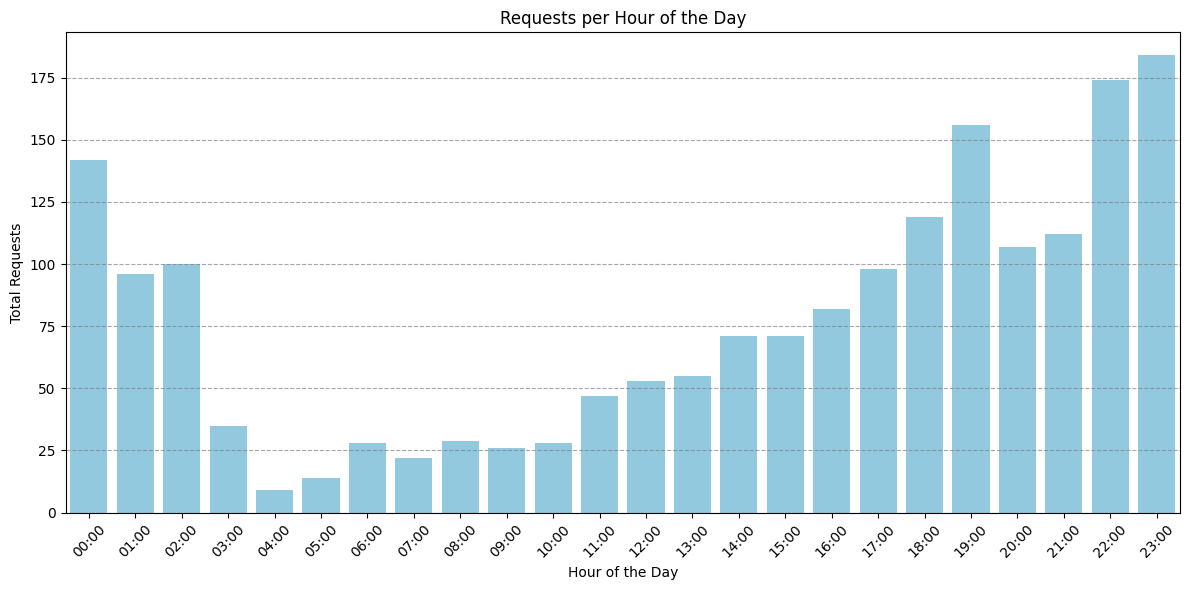

The hour of the day with the most requests was: 23:00 with 184 requests


In [5]:
# Extract the hour from the 'DateTime' column
df_with_hour = df.withColumn('HourOfDay', hour(col('DateTime')))

# Aggregate the data to sum the requests for each hour of the day
hourly_requests_df = df_with_hour.groupBy('HourOfDay').agg(sum('Requests').alias('TotalRequests'))

# Find the hour with the maximum number of requests
max_requests_df = hourly_requests_df.orderBy(col('TotalRequests').desc()).limit(1)
max_requests_result = max_requests_df.collect()[0]

# Extract and format the result
max_hour = max_requests_result['HourOfDay']
max_requests = max_requests_result['TotalRequests']

# Convert to Pandas
hourly_requests_pd = hourly_requests_df.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_requests_pd, x="HourOfDay", y="TotalRequests", color="skyblue")

# Format x-axis to show hours in 24-hour format with leading zeros
plt.xticks(ticks=range(0, 24), labels=[f'{i:02}:00' for i in range(24)], rotation=45)

# Add labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Total Requests")
plt.title("Requests per Hour of the Day")

# Add grid
plt.grid(visible=True, which='major', axis='y', linestyle='--', color='grey', alpha=0.7)

# Adjust layout to fit labels
plt.tight_layout()

# Display the plot
plt.show()

print(f"The hour of the day with the most requests was: {max_hour}:00 with {max_requests} requests")


## What percentages of all zeroes during the two-week period occurred on weekend (Friday at 5 pm to Sunday at 3 am)? 
Tip: The local time value is the start of the hour (e.g. 15 is the hour from 3:00 pm - 4:00 pm)

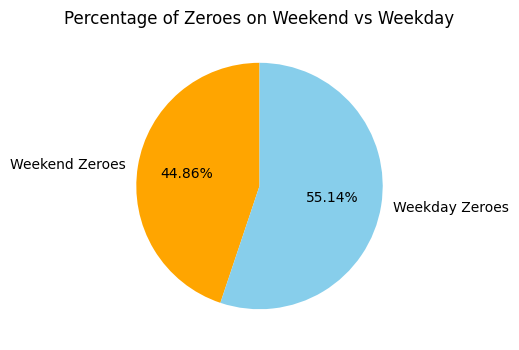

The percentage of zeros that occurred on weekend was 44.86%


In [6]:
# Calculate zeroes during weekend
weekend_zeros = df.filter(((dayofweek(col("DateTime")) == 6) & (hour(col("DateTime")) >= 17)) |
                         (dayofweek(col("DateTime")) == 7) | 
                         ((dayofweek(col("DateTime")) == 1) & (hour(col("DateTime")) < 3))).agg(sum("Zeroes").alias("weekend_zeros")).collect()[0]["weekend_zeros"]

# Calculate total zeroes
total_zeros = df.agg(sum("Zeroes").alias("Total_Zeros")).collect()[0]["Total_Zeros"]

# Calculate weekend zeroes percentage
percent_weekend_zeros = (weekend_zeros / total_zeros) * 100

# Data for plotting
labels = ['Weekend Zeroes', 'Weekday Zeroes']
sizes = [percent_weekend_zeros, 100 - percent_weekend_zeros]
colors = ['orange', 'skyblue']

# Plot
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', colors=colors, startangle=90)
plt.title("Percentage of Zeroes on Weekend vs Weekday")

# Display the plot
plt.show()

print(f"The percentage of zeros that occurred on weekend was {percent_weekend_zeros:.2f}%")

## What is the weighted average ratio of completed trips per driver during the two-week period? 
Tip: “Weighted average” means your answer should account for the total trip volume in each hour to determine the most accurate number in the whole period.

In [7]:
# Calculate the ratio of completed trips per driver for each hour
df_trips_per_driver = df.withColumn('TripsPerDriver', col('Completed Trips') / col('Unique Drivers'))

# Calculate the total completed trips for the entire period (weights) and for each hour
total_completed_trips = df_trips_per_driver.agg(sum('Completed Trips').alias('TotalCompletedTrips')).collect()[0]['TotalCompletedTrips']

# Calculate the weighted sum of ratios (sum of TripsPerDriver * Completed Trips)
weighted_sum_ratios = df_trips_per_driver.withColumn('WeightedRatio', col('TripsPerDriver') * col('Completed Trips')).agg(sum('WeightedRatio').alias('WeightedSumRatios')).collect()[0]['WeightedSumRatios']

# Compute the weighted average
weighted_average_ratio = weighted_sum_ratios / total_completed_trips

print(f"The weighted average ratio of completed trips per driver during the two-week period is: {weighted_average_ratio:.2f}")

The weighted average ratio of completed trips per driver during the two-week period is: 0.83


## In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two-week period in terms of unique requests? 
Tip: A new shift starts every 8 hours. Assume that a driver will work the same shift each day.

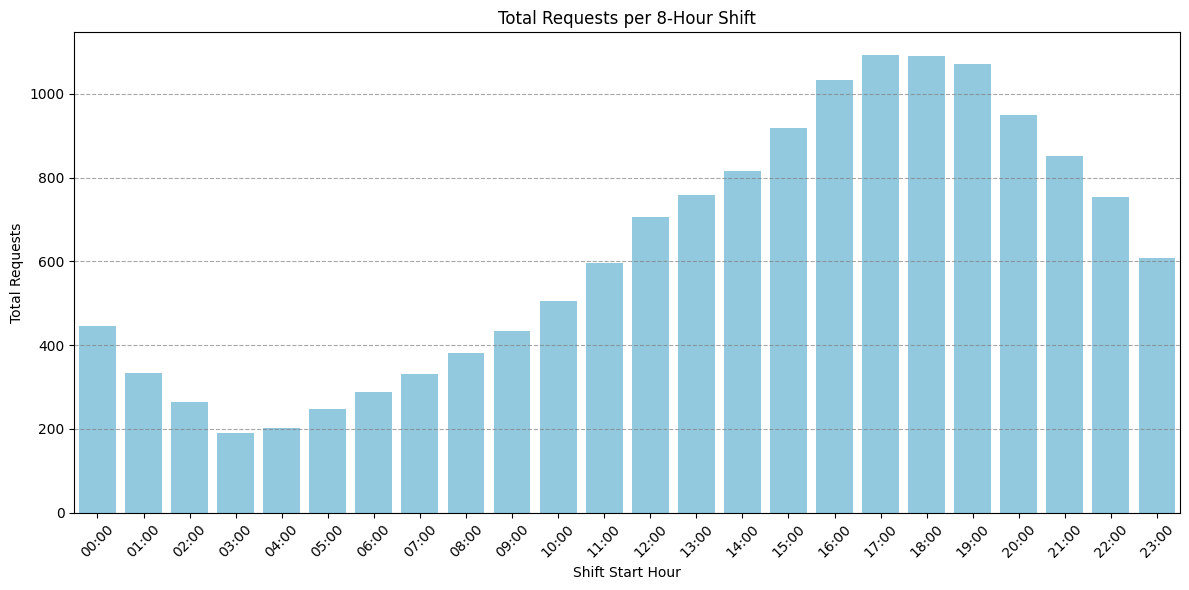

The busiest 8-hour shift over the two-week period starts at 17:00 and ends at 01:00 with 1092 total requests


In [8]:
# Extract hour and date from DateTime
df_six = df.withColumn('Hour', hour(col('DateTime')))
df_six = df_six.withColumn('Date', col('DateTime').cast('date'))

# Create an array of hours representing the start of each 8-hour shift
shift_hours = list(range(24))

# Create a DataFrame to store total requests for each shift
shift_totals = []

# Calculate total requests for each 8-hour shift
for start_hour in shift_hours:
    # Create a column for the shift end hour
    end_hour = (start_hour + 8) % 24
    
    # Filter data for the shift
    if start_hour < end_hour:
        shift_df = df_six.filter((col('Hour') >= start_hour) & (col('Hour') < end_hour))
    else:
        shift_df = df_six.filter((col('Hour') >= start_hour) | (col('Hour') < end_hour))
    
    # Sum requests for this shift across all days
    shift_total = shift_df.agg(sum('Requests').alias('TotalRequests')).withColumn('StartHour', expr(str(start_hour))).withColumn('EndHour', expr(str(end_hour)))
    shift_totals.append(shift_total)

# Union all the shift totals into one DataFrame
shift_totals_df = shift_totals[0]
for shift_total in shift_totals[1:]:
    shift_totals_df = shift_totals_df.union(shift_total)

# Identify the shift with the maximum total requests
busiest_shift = shift_totals_df.orderBy(col('TotalRequests').desc()).first()

# Extract the results
start_hour = busiest_shift['StartHour']
end_hour = busiest_shift['EndHour']
max_requests = busiest_shift['TotalRequests']

# Format the result
start_time_str = f"{int(start_hour):02d}:00"
end_time_str = f"{int(end_hour):02d}:00"

# Convert to Pandas
shift_totals_df_pd = shift_totals_df.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=shift_totals_df_pd, x="StartHour", y="TotalRequests", color="skyblue")

# Format x-axis to show hours in 24-hour format with leading zeros
plt.xticks(ticks=range(0, 24), labels=[f'{i:02}:00' for i in range(24)], rotation=45)

# Add labels and title
plt.xlabel("Shift Start Hour")
plt.ylabel("Total Requests")
plt.title("Total Requests per 8-Hour Shift")

# Add grid, adjust layout to fit labels and display the plot
plt.grid(visible=True, which='major', axis='y', linestyle='--', color='grey', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"The busiest 8-hour shift over the two-week period starts at {start_time_str} and ends at {end_time_str} with {max_requests} total requests")

## True or False: Driver supply always increases when demand increases during the two-week period. 
Tip: Visualize the data to confirm your answer if needed.

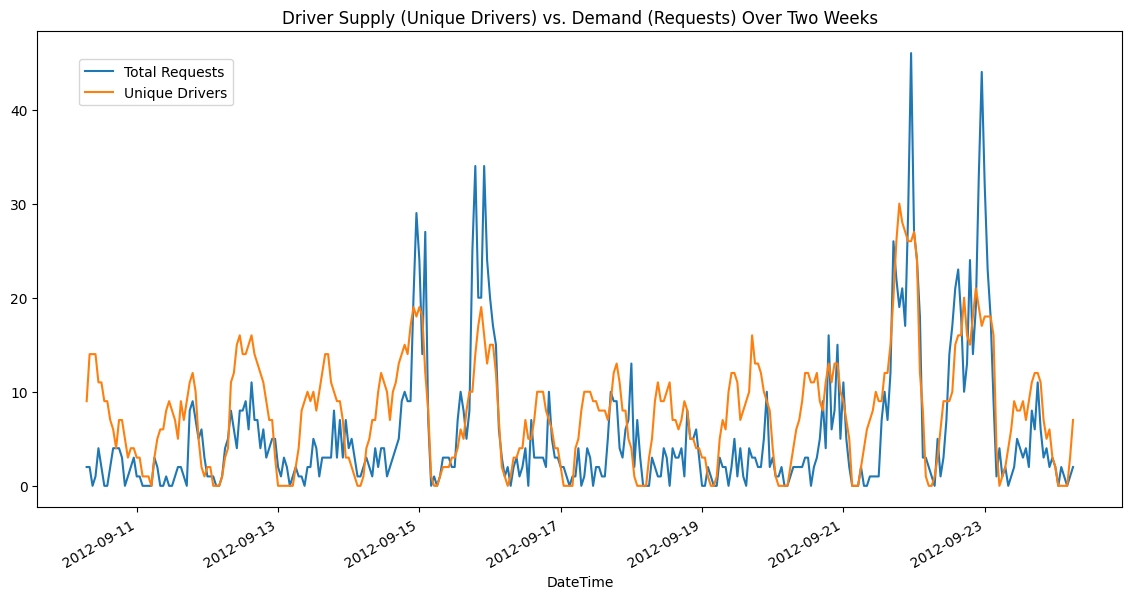

In [9]:
# Order by DateTime
hourly_data = df.orderBy('DateTime')

# Convert to Pandas DataFrame for visualization
hourly_data_pd = hourly_data.toPandas()

# Visualize the Data using Matplotlib:
import matplotlib.pyplot as plt

# Create figure, axes
fig, ax = plt.subplots(figsize=(14, 7))

# Plot total requests and unique drivers on the same axes
ax.set_xlabel('DateTime')
ax.plot(hourly_data_pd['DateTime'], hourly_data_pd['Requests'], color='tab:blue', label='Total Requests')
ax.plot(hourly_data_pd['DateTime'], hourly_data_pd['Unique Drivers'], color='tab:orange', label='Unique Drivers')

# Add legend
fig.legend(loc="upper left", bbox_to_anchor=(0.15,0.85))

# Autoformat x-axis for optimized readability
fig.autofmt_xdate()

# Add title
plt.title('Driver Supply (Unique Drivers) vs. Demand (Requests) Over Two Weeks')

# Display the plot
plt.show()

We can definitely see a 24h pattern in Unique Drivers number which tries (but often fails) to follow Requests volume and general trend however there are also many occasions when Requests rise but Unique Drivers decrease. For example the last hours of 16-09 where Unique Drivers decline after peaking while TotalRequests climb to their local peak and the TotalRequests peaks between 21-09 and 23-09 that happen when Unique Drivers number has already started going down. So the "driver supply always increases when demand increases" statement is False.

## In which 72-hour period is the ratio of Zeroes to Eyeballs the highest?

In [10]:
# Define the window specification for a 72-hour rolling period
window_spec = Window.orderBy("DateTime").rowsBetween(-71, 0)

# Calculate rolling sums
df = df.withColumn('RollingZeroes', sum('Zeroes').over(window_spec))
df = df.withColumn('RollingEyeballs', sum('Eyeballs').over(window_spec))

# Filter out periods with less than 72 hours of data
df_filtered = df.filter(col('DateTime') >= df.agg({'DateTime': 'min'}).collect()[0][0] + pd.Timedelta(hours=71))

# Calculate the ratio of Zeroes to Eyeballs
df_filtered = df_filtered.withColumn('ZeroesToEyeballsRatio', col('RollingZeroes') / col('RollingEyeballs'))

# Use a window function to rank the windows by 'ZeroesToEyeballsRatio'
window_rank_spec = Window.orderBy(col('ZeroesToEyeballsRatio').desc())
df_with_rank = df_filtered.withColumn('rank', row_number().over(window_rank_spec))

# Filter to get the window with the maximum 'ZeroesToEyeballsRatio'
max_window_df = df_with_rank.filter(col('rank') == 1).select('DateTime', 'ZeroesToEyeballsRatio')

# Collect the result
max_window_result = max_window_df.collect()[0]

# Extract the DateTime for the maximum ratio and calculate the start time
end_time = max_window_result['DateTime']
start_time = end_time - pd.Timedelta(hours=71)

# Format the start and end times 
formatted_start_time = start_time.strftime("%d-%m-%y %H:00")
formatted_end_time = (end_time + pd.Timedelta(hours=1)).strftime("%d-%m-%y %H:00")

# Output the result
formatted_start_time, formatted_end_time, max_window_result['ZeroesToEyeballsRatio']
print(f"The 72-hour period with the highest Zeroes to Eyeballs ratio is between {formatted_start_time} and {formatted_end_time} reaching {max_window_result['ZeroesToEyeballsRatio']:.2f}")


The 72-hour period with the highest Zeroes to Eyeballs ratio is between 15-09-12 05:00 and 18-09-12 05:00 reaching 0.29


## If you could add 5 drivers to any single hour of every day during the two-week period, which hour should you add them to? Hint: Consider both rider eyeballs and driver supply when choosing.

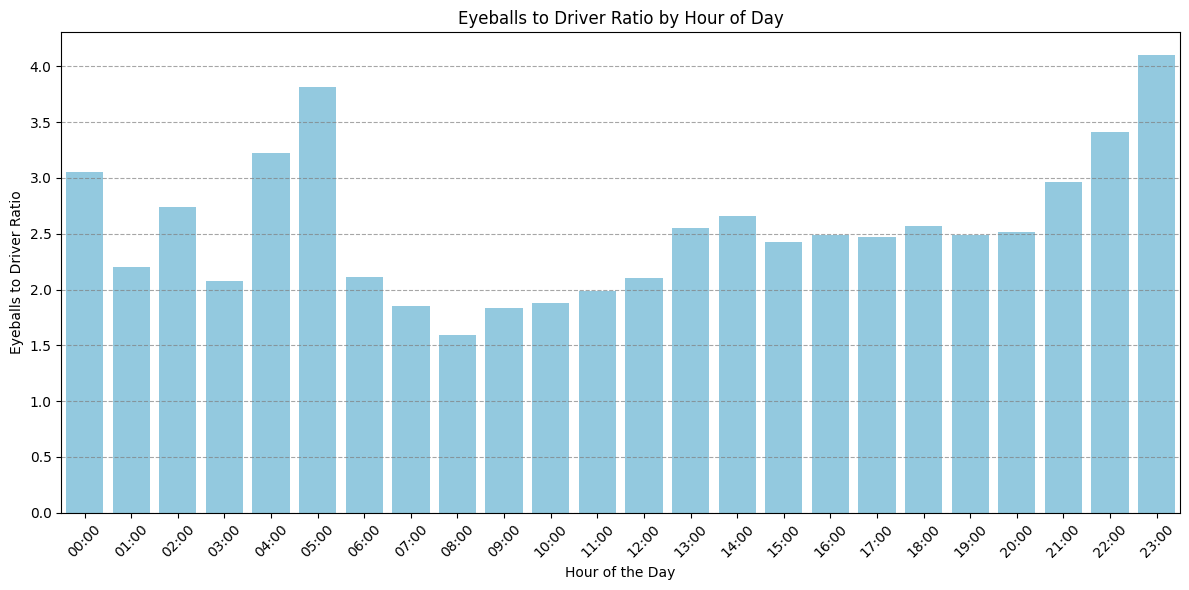

The best hour to add 5 drivers is 23:00 with an eyeballs to driver ratio of 4.10
After adjustment, the best hour to add 5 drivers is 23:00 with an adjusted eyeballs to driver ratio of 3.94


In [11]:
# Group by hour of the day
df_9 = df_with_hour.groupBy('HourOfDay').agg(
    sum('Eyeballs').alias('TotalEyeballs'),
    sum('Unique Drivers').alias('TotalUniqueDrivers')
)

# Calculate the eyeballs to driver ratio
df_9 = df_9.withColumn('EyeballsToDriverRatio', col('TotalEyeballs') / col('TotalUniqueDrivers'))

# Find the hour with the highest eyeballs to driver ratio
max_ratio_hour = df_9.orderBy(col('EyeballsToDriverRatio').desc()).first()

# Extract the hour and ratio
best_hour = max_ratio_hour['HourOfDay']
best_ratio = max_ratio_hour['EyeballsToDriverRatio']

# Convert to Pandas
df_9_pd = df_9.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_9_pd, x="HourOfDay", y="EyeballsToDriverRatio", color="skyblue")

# Format x-axis to show hours in 24-hour format with leading zeros
plt.xticks(ticks=range(0, 24), labels=[f'{i:02}:00' for i in range(24)], rotation=45)

plt.xlabel("Hour of the Day")
plt.ylabel("Eyeballs to Driver Ratio")
plt.title("Eyeballs to Driver Ratio by Hour of Day")
plt.grid(visible=True, which='major', axis='y', linestyle='--', color='grey', alpha=0.7)
plt.tight_layout()
plt.show()

# Output the best hour and its eyeballs to driver ratio
print(f"The best hour to add 5 drivers is {best_hour}:00 with an eyeballs to driver ratio of {best_ratio:.2f}")

# Calculate the impact of adding 5 drivers to this hour
df_9 = df_9.withColumn('AdjustedEyeballsToDriverRatio', 
                                     col('TotalEyeballs') / (col('TotalUniqueDrivers') + 5))

# Find the hour with the highest adjusted ratio
adjusted_max_ratio_hour = df_9.orderBy(col('AdjustedEyeballsToDriverRatio').desc()).first()

# Extract the adjusted hour and ratio
adjusted_best_hour = adjusted_max_ratio_hour['HourOfDay']
adjusted_best_ratio = adjusted_max_ratio_hour['AdjustedEyeballsToDriverRatio']

# Output the best hour to add 5 drivers after adjustment
print(f"After adjustment, the best hour to add 5 drivers is {adjusted_best_hour}:00 with an adjusted eyeballs to driver ratio of {adjusted_best_ratio:.2f}")

## Looking at the data from these two weeks, which time might make the most sense to consider a true “end day” instead of midnight? 
(i.e when supply and demand both are at their natural minimums)

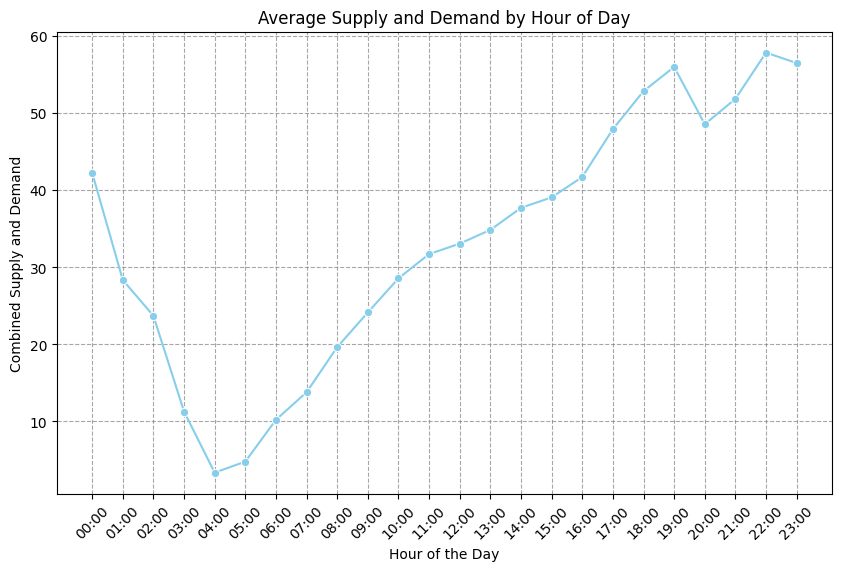

The optimal end day hour is 04:00 with an average combined supply and demand value of 3.36


In [12]:
# Group by hour of the day and calculate average supply and demand
df_10 = df_with_hour.groupBy('HourOfDay').agg(
    avg('Eyeballs').alias('AvgEyeballs'),
    avg('Requests').alias('AvgRequests'),
    avg('Unique Drivers').alias('AvgUniqueDrivers')
)

# Calculate the combined supply and demand value
df_10 = df_10.withColumn('CombinedSupplyDemand', col('AvgEyeballs') + col('AvgRequests') + col('AvgUniqueDrivers'))

# Find the hour with the minimum combined supply and demand
min_combined_hour = df_10.orderBy(col('CombinedSupplyDemand').asc()).first()

# Extract the hour and combined value
optimal_end_hour = min_combined_hour['HourOfDay']
min_combined_value = min_combined_hour['CombinedSupplyDemand']

# Convert to Pandas
df_10_pd = df_10.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_10_pd, x="HourOfDay", y="CombinedSupplyDemand", color="skyblue", marker="o")
plt.grid(visible=True, which='major', axis='both', linestyle='--', color='grey', alpha=0.7)

# Format x-axis to show hours in 24-hour format with leading zeros
plt.xticks(ticks=range(0, 24), labels=[f'{i:02}:00' for i in range(24)], rotation=45)

plt.xlabel("Hour of the Day")
plt.ylabel("Combined Supply and Demand")
plt.title("Average Supply and Demand by Hour of Day")
plt.show()

# Output the optimal end hour and its combined value
print(f"The optimal end day hour is {optimal_end_hour:02}:00 with an average combined supply and demand value of {min_combined_value:.2f}")

# Closing remarks
This brings us to a close, as we managed to answer all the questions posed. The answers should help drivers and the service itself maximize efficiency and improve customer experience.  
In addition, even if this PySpark project is limited to analysis only, it is yet another proof that even from a relatively small dataset, we can draw meaningful insights and answer questions that can be crucial to stakeholders' decision making.